# Multi-armed Bandit Code Walkthrough

**Author: Febi Agil Ifdillah**

**Web: http://febiagil.me**

**github: agilajah**

## Introduction

In this walkthrough, we'll be implementing some bandit algorithms to solve the multi-armed bandits algorithm. The algorithms that we're going to implement is epsilon greedy and ucb1.

In [0]:
import numpy as np 
import matplotlib.pyplot as plt 

## The Bandits

Here, we use Gaussian (normal) distribution with  *sigma* = 1 (*variance*), *mean* = 0, dan 15 bandits.

In [0]:
n_bandits = 15

class multiArmedBandit: 
    def __init__(self, est_values = np.zeros(n_bandits)):
        self.num_bandits = n_bandits
        self.arm_values = np.random.normal(0, 1, self.num_bandits) 
        self.best_proba = max(self.arm_values)
        self.K = np.zeros(self.num_bandits) # Initialize the number of action/bandit with zeros
        self.est_values = est_values # Initialiaze the estimate value of each bandit
        self.regret = 0. # Cumulative regret.
        self.regrets = [0.] # History of cumulative regret.
        self.t = 0
        
    def get_reward(self, action): 
        noise = np.random.normal(0,1) 
        reward = self.arm_values[action] + noise # adds Gaussian noise with sigma = 1 and mean 0 to the reward 
        return reward 

    def choose_action(self, epsilon=0, mode='ucb1'):
        self.t += 1
        if mode=='ucb1':
          # Pick the best one with consideration of upper confidence bounds.
          return max(range(n_bandits), key=lambda x: self.est_values[x] + np.sqrt(2 * np.log(self.t) / (1 + self.K[x])))
        else:
          # an epsilon number of total choice would be non-greedy actions, 
          # 1 - epsilon the rest would be greedy actions
          rand_num = np.random.rand(1) 
          if epsilon>rand_num:
            return np.random.randint(self.num_bandits)
          else: 
            return np.argmax(self.est_values)
    
    def update_regret(self, i):
        # i (int): index of the selected machine.
        self.regret += self.best_proba - self.arm_values[i]
        self.regrets.append(self.regret)

    def update_estimation(self, action, reward): 
        self.K[action] += 1 # how many times this action been chosen
        alpha = 1./self.K[action] # step-size parameter
        self.est_values[action] += alpha * (reward - self.est_values[action]) # update the estimate with new value


## Experiment - 1

We've got k number of bandits, each with its own reward distributed in normal distribution.
In this experimen, we're going to make some kind of a scoreboard to keep the total reward received by each bandit. Then, we're goint to let the agent to guess which bandit is most promising?


In [0]:
def experiment_guess(bandit, Npulls, epsilon):
    i = 0
    total_reward = np.zeros(bandit.num_bandits) # Initialize the scoreboard with zeros
    print 'Initial scoreboard:' + str(total_reward)
    print 'Bandit value(true) : '
    print str(bandit.arm_values)
    for i in range(Npulls):
        action = bandit.choose_action(epsilon, mode='greedy')
        total_reward[action] = bandit.get_reward(action)
        bandit.update_estimation(action, total_reward[action])
        bandit.update_regret(action)
        if (i % 100) == 0:
            print "Received reward for " + str(n_bandits) + " bandit :" 
            print str(total_reward)
        i+=1
        
    # agent guess which bandit is most promising
    print "The most promising bandit is  "+ str(np.argmax(bandit.est_values)+1)

    if (np.argmax(bandit.est_values) == np.argmax(bandit.arm_values)):
        print "... and it's correct!"
    else:
        print "... and it's WRONG!"  

In [4]:
Nexperiments = 5 # number of experiments will take place for each epsilon
Npulls = 2500 # number of pulling events in each experiment
epsilon = 0.5

avg_outcome_eps0p1 = np.zeros(Npulls) # average of the rewards for epsilon = 0.1

for i in range(Nexperiments): 
   bandit = multiArmedBandit() 
   experiment_guess(bandit, Npulls, epsilon) 

Initial scoreboard:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Bandit value(true) : 
[-0.45402604  1.02295755 -0.34530849 -0.27770213  1.02618075  3.04492536
  0.27107167 -0.93412105 -1.46867337 -0.78678566 -0.98537123 -0.61233665
 -1.11328178 -0.0235017  -0.1722118 ]
Received reward for 15 bandit :
[-0.63993972  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Received reward for 15 bandit :
[ 1.39468456 -1.39077215 -0.82820309 -0.51964656  0.29452903  2.58564844
  1.15203122 -0.76273442 -1.13832005  0.41175086 -0.02042686 -0.1008671
 -0.71311274 -3.05557958  0.69287653]
Received reward for 15 bandit :
[-2.12256955  0.66385196 -1.3082159   0.14655163  0.85303842  4.52228145
  0.21798882 -2.26147676 -1.70895093 -0.16395033 -0.9926663   0.3379291
 -2.74561095 -0.42062923  0.099798  ]
Received reward for 15 bandit :
[-1.35145593  0.80331865 -1.3082159  -0.85554614  1.06775287  2.99

## Experiment 2 - epsilon greedy

Let us modify a bit of the experiment_guess function to see how different value of epsilon affects the algorithm behaviour.

In [0]:
def experiment_greedy(bandit, Npulls, epsilon):
    history = []
    cregret = []
    for i in range(Npulls): 
        action = bandit.choose_action(epsilon, mode='greedy')
        R = bandit.get_reward(action) 
        bandit.update_estimation(action,R) 
        bandit.update_regret(action)
        history.append(R) 
        cregret.append(bandit.regret)
    return np.array(history), np.array(cregret)

Nantinya, kita akan mencoba beberapa nilai epsilon. Untuk setiap nilai epsilon akan dijalankan beberapa kali eksperimen
yang terdiri dari sejumlah aksi penarikan tuas bandit-bandit. Kita akan terus mencatat hasil dari setiap eksperimen
dan membandingkan bagaimana hasil *reward* untuk setiap epsilon.

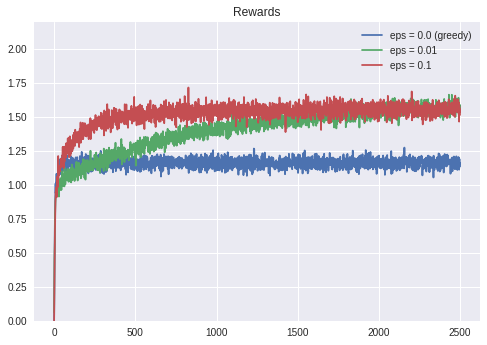

In [6]:
Nexperiments = 1000 # number of experiments will take place for each epsilon
Npulls = 2500 # number of pulling events in each experiment

avg_outcome_eps0p0 = np.zeros(Npulls) # average reward for epsilon 0.0  (greedy)
avg_outcome_eps0p01 = np.zeros(Npulls) # average reward for epsilon 0.01
avg_outcome_eps0p1 = np.zeros(Npulls) # average reward for epsilon 0.1
regret_eps0p0 = np.zeros(Npulls)
regret_eps0p01 = np.zeros(Npulls)
regret_eps0p1 = np.zeros(Npulls)

for i in range(Nexperiments): 
   bandit_test1 = multiArmedBandit() 
   treward, tregret = experiment_greedy(bandit_test1, Npulls, 0.0)
   avg_outcome_eps0p0 += treward
   regret_eps0p0 += tregret
  
  
   bandit_test2 = multiArmedBandit() 
   treward, tregret = experiment_greedy(bandit_test2, Npulls, 0.01)
   avg_outcome_eps0p01 += treward
   regret_eps0p01 += tregret
  
   bandit_test3 = multiArmedBandit() 
   treward, tregret = experiment_greedy(bandit_test3, Npulls, 0.1)
   avg_outcome_eps0p1 += treward
   regret_eps0p1 += tregret

avg_outcome_eps0p0 /= np.float(Nexperiments) 
avg_outcome_eps0p01 /= np.float(Nexperiments) 
avg_outcome_eps0p1 /= np.float(Nexperiments) 
regret_eps0p0 /= np.float(Nexperiments) 
regret_eps0p01 /= np.float(Nexperiments)
regret_eps0p1 /= np.float(Nexperiments)

plt.title("Rewards")
plt.plot(avg_outcome_eps0p0,label="eps = 0.0 (greedy)") 
plt.plot(avg_outcome_eps0p01,label="eps = 0.01") 
plt.plot(avg_outcome_eps0p1,label="eps = 0.1") 
plt.ylim(0,2.2) 
plt.legend() 
plt.show()



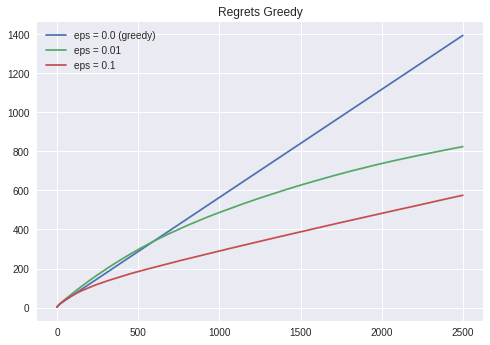

In [7]:
# This following figure is to show the regret
plt.figure(1)
plt.title("Regrets Greedy")
plt.plot(regret_eps0p0,label="eps = 0.0 (greedy)") 
plt.plot(regret_eps0p01,label="eps = 0.01") 
plt.plot(regret_eps0p1,label="eps = 0.1") 
plt.legend() 
plt.show()

## Experiment 3 - Alternative for encouraging exploration in stationary bandit (Optimistic initial values)

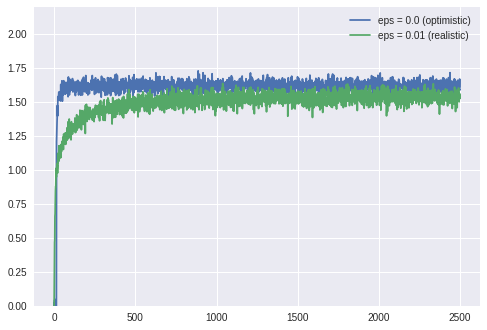

In [8]:
Nexperiments = 1000 # banyaknya eksperimen yang dijalankan untuk tiap epsilon
Npulls = 2500 # banyaknya penarikan dalam satu kali eksperimen

avg_outcome_eps0p0 = np.zeros(Npulls) # rata-rata reward untuk epsilon 0.0 (greedy)
avg_outcome_eps0p01 = np.zeros(Npulls) # rata-rata reward untuk epsilon 0.01
regret_eps0p0 = np.zeros(Npulls)
regret_eps0p01 = np.zeros(Npulls)

for i in range(Nexperiments): 
   bandit_realistic = multiArmedBandit() 
   treward, tregret = experiment_greedy(bandit_realistic, Npulls, 0.1)
   avg_outcome_eps0p01 += treward
   regret_eps0p01 += tregret
  
  
   bandit_optimistic = multiArmedBandit(np.full(n_bandits, 5.)) # initiates estimate values with 5.
   treward, tregret = experiment_greedy(bandit_optimistic, Npulls, 0.0)
   avg_outcome_eps0p0 += treward
   regret_eps0p0 += tregret

avg_outcome_eps0p0 /= np.float(Nexperiments) 
avg_outcome_eps0p01 /= np.float(Nexperiments)
regret_eps0p0 /= np.float(Nexperiments) 
regret_eps0p01 /= np.float(Nexperiments)

plt.plot(avg_outcome_eps0p0,label="eps = 0.0 (optimistic)") 
plt.plot(avg_outcome_eps0p01,label="eps = 0.01 (realistic)") 
plt.ylim(0,2.2) 
plt.legend() 
plt.show()

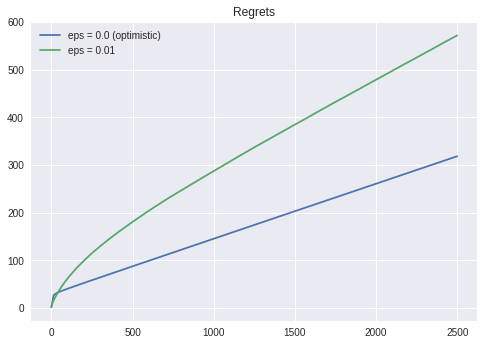

In [9]:
plt.figure(2)
plt.title("Regrets")
plt.plot(regret_eps0p0,label="eps = 0.0 (optimistic)") 
plt.plot(regret_eps0p01,label="eps = 0.01") 
plt.legend() 
plt.show()

## Experiment 4 - UCB1

In [0]:
def experiment_ucb1(bandit, Npulls, epsilon=0):
    history = []
    cregret = []
    for i in range(Npulls): 
        action = bandit.choose_action(epsilon, mode='ucb1')
        R = bandit.get_reward(action) 
        bandit.update_estimation(action,R) 
        bandit.update_regret(action)
        history.append(R) 
        cregret.append(bandit.regret)
    return np.array(history), np.array(cregret)

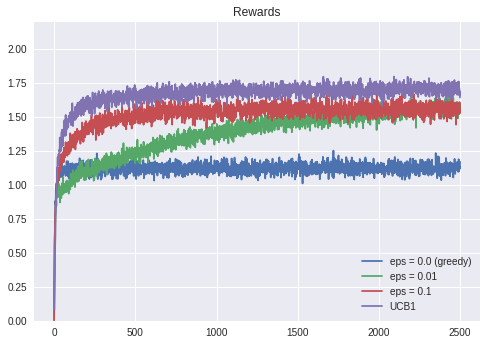

In [11]:
Nexperiments = 1000 # number of experiments will take place for each epsilon
Npulls = 2500 # number of pulling events in each experiment

avg_outcome_eps0p0 = np.zeros(Npulls) # average reward for epsilon 0.0  (greedy)
avg_outcome_eps0p01 = np.zeros(Npulls) # average reward for epsilon 0.01
avg_outcome_eps0p1 = np.zeros(Npulls) # average reward for epsilon 0.1
avg_outcome_ucb1 = np.zeros(Npulls)
regret_eps0p0 = np.zeros(Npulls)
regret_eps0p01 = np.zeros(Npulls)
regret_eps0p1 = np.zeros(Npulls)
regret_ucb1 = np.zeros(Npulls)

for i in range(Nexperiments): 
   bandit_test1 = multiArmedBandit() 
   treward, tregret = experiment_greedy(bandit_test1, Npulls, 0.0)
   avg_outcome_eps0p0 += treward
   regret_eps0p0 += tregret
  
  
   bandit_test2 = multiArmedBandit() 
   treward, tregret = experiment_greedy(bandit_test2, Npulls, 0.01)
   avg_outcome_eps0p01 += treward
   regret_eps0p01 += tregret
  
   bandit_test3 = multiArmedBandit() 
   treward, tregret = experiment_greedy(bandit_test3, Npulls, 0.1)
   avg_outcome_eps0p1 += treward
   regret_eps0p1 += tregret
  
   bandit_test4 = multiArmedBandit() 
   treward, tregret = experiment_ucb1(bandit_test4, Npulls)
   avg_outcome_ucb1 += treward
   regret_ucb1 += tregret
  
   

avg_outcome_eps0p0 /= np.float(Nexperiments) 
avg_outcome_eps0p01 /= np.float(Nexperiments) 
avg_outcome_eps0p1 /= np.float(Nexperiments) 
avg_outcome_ucb1 /= np.float(Nexperiments)                                     
regret_eps0p0 /= np.float(Nexperiments) 
regret_eps0p01 /= np.float(Nexperiments)
regret_eps0p1 /= np.float(Nexperiments)
regret_ucb1 /= np.float(Nexperiments)

plt.figure(3)
plt.title("Rewards")
plt.plot(avg_outcome_eps0p0,label="eps = 0.0 (greedy)") 
plt.plot(avg_outcome_eps0p01,label="eps = 0.01") 
plt.plot(avg_outcome_eps0p1,label="eps = 0.1") 
plt.plot(avg_outcome_ucb1,label="UCB1") 
plt.ylim(0,2.2) 
plt.legend() 
plt.show()



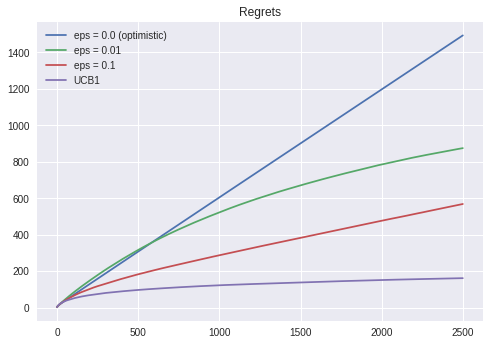

In [12]:
plt.figure(4)
plt.title("Regrets")
plt.plot(regret_eps0p0,label="eps = 0.0 (optimistic)") 
plt.plot(regret_eps0p01,label="eps = 0.01") 
plt.plot(regret_eps0p1,label="eps = 0.1")
plt.plot(regret_ucb1,label="UCB1")
plt.legend() 
plt.show()